# Raster plotting of river profiles along the San Andreas fault
This notebook makes a plot of the raster hillshade, the channels coloured by their gradient, and the basins for a single tile along the San Andreas fault. You must specify the base directory for each tile.

Raster I/O is done using rasterio and plotting is done using cartopy. I use geopandas to read in the channel data.

In [1]:
import cartopy as cp
import cartopy.crs as ccrs
import rasterio as rio
import rasterio.mask
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import geopandas as gpd

First, specify the name of the tile and the base directory

In [17]:
tile_no = 'SouthernSAF_17'
base_dir = '/home/bjdd72/san_andreas/'+tile_no+'/'

Now we'll use rasterio to read in the DEM and check the coordinate system

In [18]:
DEM = rio.open(base_dir+tile_no+'_HS.tif')
print(DEM.crs)
DEM.nodata

EPSG:32611


0.0

We can read the raster to an array and get the extent for cartopy plotting

In [19]:
bounds = DEM.bounds
# The data format is left, right, bottom, top (WARNING: this is a different order to the bounds in rasterio)
Extent = [bounds.left,bounds.right,bounds.bottom,bounds.top]
array = DEM.read(1)
array = array.astype('float')
array[array==0]=np.nan

## Read in the channel data

We will now read the river channel csv. This contains information about each 3rd order river in the tile. We'll use geopandas to read in the data

In [20]:
df = pd.read_csv(base_dir+tile_no+'_profiles_SO3.csv')
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf = gdf.set_crs(epsg=4326)
# convert to same UTM zone as raster
gdf2 = gdf.to_crs(str(DEM.crs))
# remove NaNs
gdf2 = gdf2[gdf2['slope'] < 9999]

## Read in the basins

Read in the 3rd order basins shapefile to a pandas geodataframe


In [21]:
basins_gdf = gpd.read_file(base_dir+tile_no+'_basins2.shp')
# convert the polygon geometry to UTM
basins_utm = basins_gdf.to_crs(str(DEM.crs))
print(basins_utm)

     basin_id    basin_area     azimuth  deflection   latitude   longitude  \
0        6299      1.000000  273.468910   38.695753  36.063951 -120.624885   
1        6299      1.000000   44.115295   81.222852  36.063951 -120.624885   
2        6299  22728.000000   58.789873   67.599715  36.063951 -120.624885   
3        6121  15857.000000   63.318936   63.632473  36.064912 -120.624734   
4        6361  18369.000000  251.579723   56.609272  36.062978 -120.624004   
..        ...           ...         ...         ...        ...         ...   
223      6256  39200.964863  178.187701   49.469023  35.997151 -120.552008   
224      6277  15337.676523  199.005367   74.571682  35.997147 -120.551831   
225      6479  17314.904455   43.547891   79.184206  35.996380 -120.553382   
226      6565  23464.808543   23.355453   79.543947  35.995185 -120.551765   
227      6567  23542.815196  353.257802   43.412716  35.994937 -120.551011   

     fault_dist  direction                                     

## Read in the fault shapefile

Read in the shapefile of the San Andreas fault so we can plot the strike

In [22]:
SAF = gpd.read_file('/home/bjdd72/san_andreas/SanAndreasFault.shp')
SAF_UTM = SAF.to_crs(str(DEM.crs))

## Plotting
We'll now put all these together and plot the hillshade and the 3rd order basins. We'll overlay this with the rivers and colour the points by the channel slope.

<GeoAxesSubplot:>

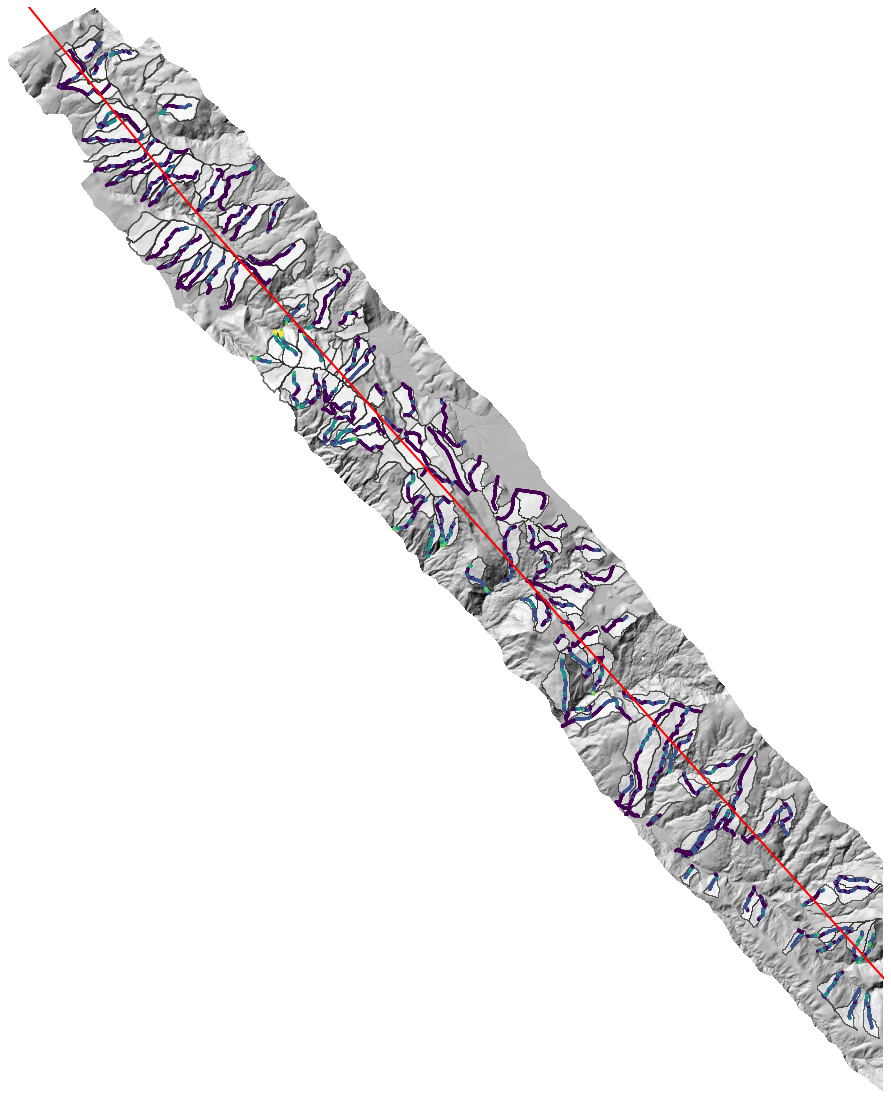

In [23]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(10))
# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(Extent, crs=ccrs.UTM(10))
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#print('Projecting and plotting image (this may take a while)...')
ax.imshow(array, extent=Extent, transform=ccrs.UTM(10), origin="upper", cmap='gray', alpha=1, zorder=2)
ax.axis('off')

# now plot the channel data. We need to normalise the colours on a 0 to 1 scale
norm = colors.Normalize(vmin=0, vmax=1)
this_cmap = plt.cm.get_cmap('viridis', 5)
gdf2.plot(ax=ax, column='slope', markersize=4, zorder=10, cmap=this_cmap, norm=norm)

# now plot the basins 
basins_utm.plot(ax=ax, facecolor='white', edgecolor='k', alpha=0.6, zorder=5)

# now plot the SAF fault strike
SAF_UTM.plot(ax=ax, edgecolor='red', lw=2, zorder=15)

In [24]:
# save the figure
fig.savefig(base_dir+tile_no+'_raster_plot.png', dpi=300)

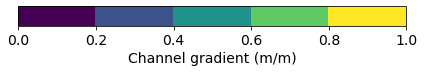

In [29]:
# Make a new figure to save the colourbar separately
fig,ax2 = plt.subplots()

# create the colourbar
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=this_cmap), ax=ax2, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Channel gradient (m/m)', fontsize=14)
ax2.remove()
plt.tight_layout()
fig.savefig(base_dir+tile_no+'_raster_plot_cbar.png', dpi=300)